# Mixing Experiments for Kikuchi Patterns

This notebook is a sandbox for exploring how to mix pure patterns A and B to form a realistic mixed pattern C. It uses the sample data in `data/code_development_data/` by default.

Run this notebook from the `notebooks/` folder or the repository root. The code will auto-detect the repo root and add it to `sys.path` so `src/` imports work.


## Goals

- Compare mixing pipelines (normalize-then-mix vs mix-then-normalize)
- Add blur, noise, and gamma to mimic detector effects
- Use circular masks and smart normalization to avoid skew from masked zeros
- Score synthetic C against a real C (if available) using PSNR/SSIM


In [43]:
from __future__ import annotations

import math
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Repo path setup
ROOT = Path("..").resolve()
if not (ROOT / "src").exists():
    ROOT = Path(".").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Optional dependencies
try:
    import torch
    HAS_TORCH = True
except Exception:
    torch = None
    HAS_TORCH = False

try:
    import ipywidgets as widgets
    from IPython.display import display
    HAS_WIDGETS = True
except Exception:
    widgets = None
    display = None
    HAS_WIDGETS = False

try:
    from scipy.ndimage import gaussian_filter
    HAS_SCIPY = True
except Exception:
    gaussian_filter = None
    HAS_SCIPY = False

print(f"ROOT: {ROOT}")
print(f"torch: {HAS_TORCH}, ipywidgets: {HAS_WIDGETS}, scipy: {HAS_SCIPY}")


ROOT: /home/kvmani/DeepImageDeconvolution
torch: True, ipywidgets: True, scipy: True


In [44]:
# Default file paths (override as needed)
A_PATH = ROOT / "data" / "code_development_data" / "image_A.png"
B_PATH = ROOT / "data" / "code_development_data" / "image_B.png"
C_PATH = ROOT / "data" / "code_development_data" / "image_C.png"  # Optional target C

# Preprocessing settings
USE_MASK = True
DETECT_EXISTING_MASK = True
ZERO_TOLERANCE = 5e-4
OUTSIDE_ZERO_FRACTION = 0.98

NORMALIZE_ENABLED = False
NORMALIZE_METHOD = "min_max"  # min_max, max, percentile, histogram_equalization
SMART_NORMALIZE = True
HIST_BINS = 1024
PERCENTILE = (1.0, 99.0)

# Mixing settings
PIPELINE = "normalize_then_mix"  # normalize_then_mix or mix_then_normalize
WEIGHT_A = 0.6
WEIGHT_B = 1.0 - WEIGHT_A

BLUR_SIGMA = 0.0
GAUSS_NOISE_STD = 0.0
POISSON_LAMBDA = 0.0
GAMMA = 1.0
EXPOSURE_GAIN = 1.0


In [45]:
from src.preprocessing.mask import apply_circular_mask, build_circular_mask, detect_circular_mask
from src.preprocessing.normalise import normalize_image
from src.utils.io import read_image_16bit, to_float01, write_image_16bit
from src.utils.metrics import aggregate_metrics


def load_image(path: Path) -> np.ndarray:
    # Load a 16-bit image and convert to float32 in [0, 1]
    image = read_image_16bit(path)
    return to_float01(image)


def compute_mask(image: np.ndarray) -> tuple[np.ndarray, dict]:
    # Create a circular mask and optionally detect existing masking
    mask = build_circular_mask(image.shape)
    meta = {}
    if DETECT_EXISTING_MASK:
        detected, fraction = detect_circular_mask(
            image,
            mask,
            zero_tolerance=ZERO_TOLERANCE,
            outside_zero_fraction=OUTSIDE_ZERO_FRACTION,
        )
        meta["detected"] = detected
        meta["outside_zero_fraction"] = fraction
    return mask, meta


def preprocess(image: np.ndarray, mask: np.ndarray | None) -> np.ndarray:
    # Apply optional masking and normalization
    if USE_MASK and mask is not None:
        image = apply_circular_mask(image, mask)
    if NORMALIZE_ENABLED:
        image = normalize_image(
            image,
            method=NORMALIZE_METHOD,
            histogram_bins=HIST_BINS,
            percentile=PERCENTILE,
            mask=mask,
            smart_minmax=SMART_NORMALIZE,
        )
    return image.astype(np.float32)


def apply_gamma(image: np.ndarray, gamma: float) -> np.ndarray:
    # Gamma correction in [0, 1]
    if gamma <= 0:
        raise ValueError("gamma must be > 0")
    return np.clip(image, 0.0, 1.0) ** gamma


def apply_exposure(image: np.ndarray, gain: float) -> np.ndarray:
    # Linear exposure scaling
    return np.clip(image * gain, 0.0, 1.0)


def apply_blur(image: np.ndarray, sigma: float) -> np.ndarray:
    # Gaussian blur if scipy is available
    if sigma <= 0:
        return image
    if not HAS_SCIPY:
        raise RuntimeError("scipy is required for blur. Install scipy or set BLUR_SIGMA=0.")
    return gaussian_filter(image, sigma=sigma).astype(np.float32)


def apply_noise(image: np.ndarray, std: float, poisson_lambda: float, rng: np.random.Generator) -> np.ndarray:
    # Add Gaussian and Poisson noise
    noisy = image
    if std > 0:
        noise = rng.normal(0.0, std, size=image.shape).astype(np.float32)
        noisy = np.clip(noisy + noise, 0.0, 1.0)
    if poisson_lambda > 0:
        scaled = np.clip(noisy * poisson_lambda, 0.0, None)
        noisy = rng.poisson(scaled).astype(np.float32) / float(poisson_lambda)
        noisy = np.clip(noisy, 0.0, 1.0)
    return noisy


def mix_images(
    image_a: np.ndarray,
    image_b: np.ndarray,
    weight_a: float,
    pipeline: str,
    mask: np.ndarray | None,
) -> np.ndarray:
    # Mix two images using selected pipeline
    weight_b = 1.0 - weight_a
    if pipeline == "normalize_then_mix":
        a_norm = normalize_image(
            image_a,
            method=NORMALIZE_METHOD,
            histogram_bins=HIST_BINS,
            percentile=PERCENTILE,
            mask=mask,
            smart_minmax=SMART_NORMALIZE,
        ) if NORMALIZE_ENABLED else image_a
        b_norm = normalize_image(
            image_b,
            method=NORMALIZE_METHOD,
            histogram_bins=HIST_BINS,
            percentile=PERCENTILE,
            mask=mask,
            smart_minmax=SMART_NORMALIZE,
        ) if NORMALIZE_ENABLED else image_b
        mixed = weight_a * a_norm + weight_b * b_norm
    elif pipeline == "mix_then_normalize":
        mixed = weight_a * image_a + weight_b * image_b
        if NORMALIZE_ENABLED:
            mixed = normalize_image(
                mixed,
                method=NORMALIZE_METHOD,
                histogram_bins=HIST_BINS,
                percentile=PERCENTILE,
                mask=mask,
                smart_minmax=SMART_NORMALIZE,
            )
    else:
        raise ValueError(f"Unknown pipeline: {pipeline}")
    if mask is not None and USE_MASK:
        mixed = apply_circular_mask(mixed, mask)
    return np.clip(mixed, 0.0, 1.0).astype(np.float32)


In [46]:
# Load images
image_a = load_image(A_PATH)
image_b = load_image(B_PATH)
image_c = load_image(C_PATH) if C_PATH.exists() else None

mask, mask_meta = (None, {})
if USE_MASK:
    mask, mask_meta = compute_mask(image_c if image_c is not None else image_a)
    print("Mask detection:", mask_meta)

image_a = preprocess(image_a, mask)
image_b = preprocess(image_b, mask)
if image_c is not None:
    image_c = preprocess(image_c, mask)

print("A range", image_a.min(), image_a.max())
print("B range", image_b.min(), image_b.max())
if image_c is not None:
    print("C range", image_c.min(), image_c.max())


Mask detection: {'detected': False, 'outside_zero_fraction': 0.9583451805516064}
A range 0.0 0.99220264
B range 0.0 0.99220264
C range 0.0 0.9297017


In [47]:
from matplotlib.patches import Circle


def plot_panel(a: np.ndarray, b: np.ndarray, c: np.ndarray | None, mix: np.ndarray, mask: np.ndarray | None) -> None:
    # Plot A, B, C (optional), and mixed output with annotations
    fig, axes = plt.subplots(1, 4 if c is not None else 3, figsize=(14, 4))
    axes = np.atleast_1d(axes)

    axes[0].imshow(a, cmap="gray")
    axes[0].set_title("A")
    axes[0].axis("off")

    axes[1].imshow(b, cmap="gray")
    axes[1].set_title("B")
    axes[1].axis("off")

    if c is not None:
        axes[2].imshow(c, cmap="gray")
        axes[2].set_title("C (target)")
        axes[2].axis("off")
        mix_ax = axes[3]
    else:
        mix_ax = axes[2]

    mix_ax.imshow(mix, cmap="gray")
    mix_ax.set_title("C (synthetic)")
    mix_ax.axis("off")

    if mask is not None:
        height, width = a.shape
        center = ((width - 1) / 2.0, (height - 1) / 2.0)
        radius = min(height, width) / 2.0
        for ax in axes:
            ax.add_patch(Circle(center, radius, fill=False, color="yellow", linewidth=1.0))

    plt.tight_layout()
    plt.show()


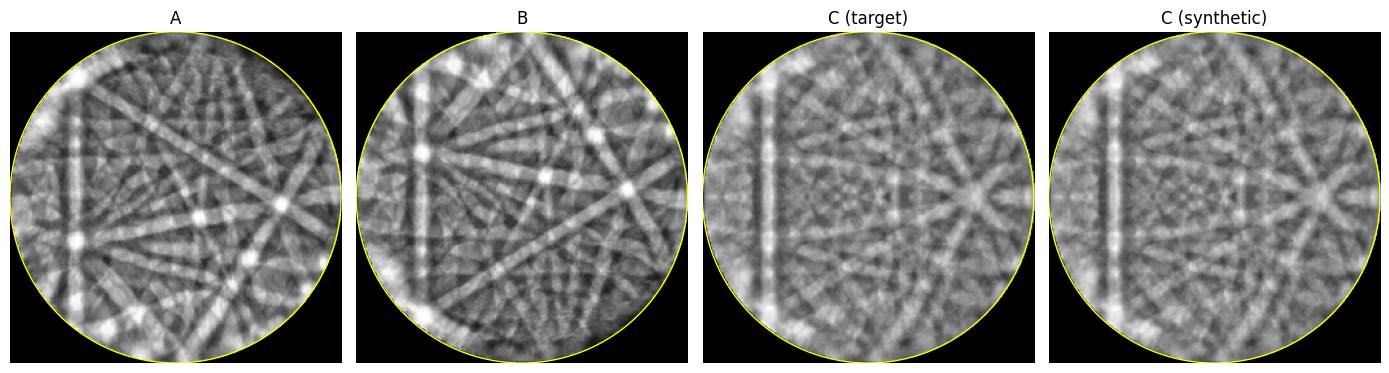

PSNR 80.000 | SSIM 0.983


In [52]:
# Single run with current parameters
rng = np.random.default_rng(0)
WEIGHT_A=0.5

mixed = mix_images(
    image_a,
    image_b,
    weight_a=WEIGHT_A,
    pipeline=PIPELINE,
    mask=mask,
)

mixed = apply_exposure(mixed, EXPOSURE_GAIN)
mixed = apply_gamma(mixed, GAMMA)
mixed = apply_blur(mixed, BLUR_SIGMA)
mixed = apply_noise(mixed, GAUSS_NOISE_STD, POISSON_LAMBDA, rng)

plot_panel(image_a, image_b, image_c, mixed, mask)

if HAS_TORCH and image_c is not None:
    pred = torch.from_numpy(mixed).unsqueeze(0).unsqueeze(0)
    target = torch.from_numpy(image_c).unsqueeze(0).unsqueeze(0)
    psnr_val, ssim_val = aggregate_metrics(pred, target)
    print(f"PSNR {psnr_val:.3f} | SSIM {ssim_val:.3f}")


In [49]:
# Grid search over a small parameter space
if image_c is None:
    print("No target C available for scoring.")
else:
    results = []
    rng = np.random.default_rng(1)
    for weight_a in [0.3, 0.5, 0.7]:
        for blur_sigma in [0.0, 1.0]:
            for noise_std in [0.0, 0.02]:
                mix = mix_images(image_a, image_b, weight_a, PIPELINE, mask)
                mix = apply_blur(mix, blur_sigma)
                mix = apply_noise(mix, noise_std, 0.0, rng)
                if HAS_TORCH:
                    pred = torch.from_numpy(mix).unsqueeze(0).unsqueeze(0)
                    target = torch.from_numpy(image_c).unsqueeze(0).unsqueeze(0)
                    psnr_val, ssim_val = aggregate_metrics(pred, target)
                else:
                    diff = (mix - image_c) ** 2
                    mse = float(diff.mean())
                    psnr_val = 10.0 * math.log10(1.0 / (mse + 1e-8))
                    ssim_val = 0.0

                results.append(
                    {
                        "weight_a": weight_a,
                        "blur_sigma": blur_sigma,
                        "noise_std": noise_std,
                        "psnr": psnr_val,
                        "ssim": ssim_val,
                    }
                )

    results = sorted(results, key=lambda x: (x["psnr"], x["ssim"]), reverse=True)
    print("Top results:")
    for row in results[:5]:
        print(row)


Top results:
{'weight_a': 0.5, 'blur_sigma': 0.0, 'noise_std': 0.0, 'psnr': 80.0, 'ssim': 0.9825069904327393}
{'weight_a': 0.5, 'blur_sigma': 0.0, 'noise_std': 0.02, 'psnr': 34.48133850097656, 'ssim': 0.8569074869155884}
{'weight_a': 0.5, 'blur_sigma': 1.0, 'noise_std': 0.0, 'psnr': 31.67115020751953, 'ssim': 0.9355831146240234}
{'weight_a': 0.5, 'blur_sigma': 1.0, 'noise_std': 0.02, 'psnr': 29.843448638916016, 'ssim': 0.8087809085845947}
{'weight_a': 0.3, 'blur_sigma': 0.0, 'noise_std': 0.0, 'psnr': 27.83266830444336, 'ssim': 0.9237581491470337}


In [50]:
# Interactive widgets (if ipywidgets is installed)
if not HAS_WIDGETS:
    print("ipywidgets is not installed. Use the manual parameter cell above.")
else:
    def _run_interactive(weight_a, blur_sigma, noise_std, gamma, exposure_gain):
        rng = np.random.default_rng(2)
        mix = mix_images(image_a, image_b, weight_a, PIPELINE, mask)
        mix = apply_exposure(mix, exposure_gain)
        mix = apply_gamma(mix, gamma)
        mix = apply_blur(mix, blur_sigma)
        mix = apply_noise(mix, noise_std, 0.0, rng)
        plot_panel(image_a, image_b, image_c, mix, mask)

    widgets.interact(
        _run_interactive,
        weight_a=widgets.FloatSlider(min=0.0, max=1.0, step=0.05, value=WEIGHT_A),
        blur_sigma=widgets.FloatSlider(min=0.0, max=3.0, step=0.2, value=BLUR_SIGMA),
        noise_std=widgets.FloatSlider(min=0.0, max=0.1, step=0.005, value=GAUSS_NOISE_STD),
        gamma=widgets.FloatSlider(min=0.5, max=2.0, step=0.05, value=GAMMA),
        exposure_gain=widgets.FloatSlider(min=0.5, max=2.0, step=0.05, value=EXPOSURE_GAIN),
    )


interactive(children=(FloatSlider(value=0.0, description='weight_a', max=1.0, step=0.05), FloatSlider(value=0.…

In [51]:
# Save a synthetic C image (optional)
SAVE_OUTPUT = False
OUTPUT_DIR = ROOT / "data" / "synthetic" / "experiments"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

if SAVE_OUTPUT:
    out_path = OUTPUT_DIR / "synthetic_C_from_A_B.png"
    write_image_16bit(out_path, mixed)
    print(f"Saved {out_path}")
else:
    print("Set SAVE_OUTPUT = True to write synthetic output.")


Set SAVE_OUTPUT = True to write synthetic output.


## Notes

- Keep images in float32 [0, 1] while experimenting. Only save to 16-bit when you decide to export.
- Masking and smart normalization prevent zeros outside the active detector area from skewing scales.
- For more realism, consider adding point spread blur and detector noise.
